# Machine Learning on AWS Cloud

## Combined Data version 1


In [1]:
# import libraries
import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### Setting up S3 bucket


In [2]:
import logging


# import boto3


from botocore.exceptions import ClientError


def create_bucket(bucket_name, region=None):
    # Create an S3 bucket in a specified region
    # If a region is not specified, the bucket is created in the S3 default
    # region (us-east-1).
    # :param bucket_name: Bucket to create
    # :param region: String region to create bucket in, e.g., 'us-west-2'
    # :return: True if bucket created, else False

    # Create bucket

    try:

        if region is None:

            s3_client = boto3.client("s3")

            s3_client.create_bucket(Bucket=bucket_name)
        else:

            s3_client = boto3.client("s3", region_name=region)

            location = {"LocationConstraint": region}

            s3_client.create_bucket(
                Bucket=bucket_name, CreateBucketConfiguration=location
            )

    except ClientError as e:

        logging.error(e)

        return False

    print(f"S3 Bucket: {bucket_name} created successfully")

    return True

In [3]:
# Function to check if the bucket exists
def check_bucket_exists(bucket_name):
    s3 = boto3.client("s3")
    try:
        s3.head_bucket(Bucket=bucket_name)
        print(f"Bucket '{bucket_name}' already exists.")
        return True
    except ClientError as e:
        # If a 404 error is raised, the bucket does not exist
        if e.response["Error"]["Code"] == "404":
            print(f"Bucket '{bucket_name}' does not exist.")
            return False
        else:
            # If there's any other error, raise it
            raise

In [5]:
# set the s3 bucket name
bucket = "u3253992-ajulthomas-oncloud"

# fetch the s3 resource
s3_resource = boto3.Session().resource("s3")


# check if bucket exists
bucket_exists = check_bucket_exists(bucket)

# Create the bucket if it doesn't exist
if not bucket_exists:
    create_bucket(bucket)

Bucket 'u3253992-ajulthomas-oncloud' already exists.


In [6]:
# setting the prefix
prefix = "oncloud"


# uploading data to aws s3
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False)
    print(s3_resource.Bucket(bucket))
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(
        Body=csv_buffer.getvalue()
    )

### Generic Functions


In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# function to plot confusion matrix
def plot_confusion_matrix(test_labels, target_predicted):
    # complete the code here
    cm = confusion_matrix(test_labels, target_predicted)
    # Create a heatmap
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["On-Time", "Delayed"],
        yticklabels=["On-Time", "Delayed"],
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

### Loading Data


In [8]:
import pandas as pd

# load the data


data_v1 = pd.read_csv("./combined_csv_v1.csv")


data_v1.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
# shape of the data
data_v1.shape

(1635590, 75)

## Model 1 - Linear Learner

---


In [10]:
# create a copt of the version 1 data

df = data_v1.copy()

df.shape

(1635590, 75)

In [11]:
df_cleaned = df.replace({True: 1, False: 0})

df_cleaned.head(5)

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [12]:
df_cleaned.isnull().sum().sum()

0

In [13]:
df_cleaned.shape

(1635590, 75)

In [14]:
# split the data

train, test_and_validate = train_test_split(
    df_cleaned, test_size=0.3, random_state=42, stratify=df_cleaned["target"]
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [15]:
# shape of train data
train.shape

(1144913, 75)

In [16]:
# shape of test
test.shape

(245338, 75)

In [17]:
# shape of validate
validate.shape

(245339, 75)

In [18]:
# set the names of the csv files
train_file = "data_v1_train.csv"
test_file = "data_v1_test.csv"
validate_file = "data_v1_validate.csv"

### Upload data to S3 Bucket


In [19]:
import io
import numpy as np
import sagemaker.amazon.common as smac


# prepare data for sagemaker training


def prepare_data(dataframe):
    vectors = dataframe.drop(columns=["target"]).values.astype("float32")
    labels = dataframe["target"].values.astype("float32")
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, vectors, labels)
    buf.seek(0)

    return buf

In [20]:
import boto3
import os


# upload training data to s3
def upload_s3_buf(buf, bucket, prefix, type):
    key = "recordio-pb-data"
    boto3.resource("s3").Bucket(bucket).Object(
        os.path.join(prefix, type, key)
    ).upload_fileobj(buf)
    s3_data_path = "s3://{}/{}/{}/{}".format(bucket, prefix, type, key)
    print("uploaded {} data to location: {}".format(type, s3_data_path))
    return s3_data_path

In [21]:
# prepare train data
train_buf = prepare_data(train)

# upload train data
s3_train_data = upload_s3_buf(train_buf, bucket, prefix, "train")

uploaded train data to location: s3://u3253992-ajulthomas-oncloud/oncloud/train/recordio-pb-data


In [22]:
# prepare validation data
validate_buf = prepare_data(validate)

# upload validation data
s3_validate_data = upload_s3_buf(validate_buf, bucket, prefix, "validate")

uploaded validate data to location: s3://u3253992-ajulthomas-oncloud/oncloud/validate/recordio-pb-data


In [23]:
output_location = "s3://{}/{}/output".format(bucket, prefix)
print("training artifacts will be uploaded to: {}".format(output_location))

training artifacts will be uploaded to: s3://u3253992-ajulthomas-oncloud/oncloud/output


In [24]:
from sagemaker.image_uris import retrieve

# container = retrieve("linear-learner", boto3.Session().region_name)
container = retrieve("linear-learner", "us-east-1")

### Training the model


In [25]:
import boto3

# sess = sagemaker.Session()

# Ensure your session is set to the same region as the bucket
session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

# Get the execution role
role = sagemaker.get_execution_role()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.c5.2xlarge",
    output_path=output_location,
    sagemaker_session=session,
)
linear.set_hyperparameters(feature_dim=74, predictor_type="binary_classifier")

linear.fit({"train": s3_train_data, "validation": s3_validate_data}, logs=False)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



2024-11-03 04:37:36 Starting - Starting the training job.
2024-11-03 04:37:50 Starting - Preparing the instances for training....
2024-11-03 04:38:13 Downloading - Downloading input data...
2024-11-03 04:38:38 Downloading - Downloading the training image.........
2024-11-03 04:39:29 Training - Training image download completed. Training in progress.........................................................................
2024-11-03 04:45:51 Uploading - Uploading generated training model.
2024-11-03 04:46:04 Completed - Training job completed


#### Preparing the test data for prediction


In [26]:
import boto3
import pandas as pd
import io

# Prepare the input data for batch prediction
batch_X_linear = test.iloc[:, 1:]
batch_X_file_linear = "batch-in-linear.csv"

# Upload the CSV to S3
upload_s3_csv(batch_X_file_linear, "batch-in-linear", batch_X_linear)

# Define the S3 paths
batch_output = "s3://{}/{}/batch-out-linear/".format(bucket, prefix)
batch_input = "s3://{}/{}/batch-in-linear/{}".format(
    bucket, prefix, batch_X_file_linear
)

s3.Bucket(name='u3253992-ajulthomas-oncloud')


#### Using Transformers to predict the results


In [27]:
# Create the transformer for the Linear Learner model
linear_transformer = linear.transformer(
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output,
)

# Start the batch transform job
linear_transformer.transform(
    data=batch_input,
    data_type="S3Prefix",
    content_type="text/csv",
    split_type="Line",
    logs=False,
)

linear_transformer.wait()

..........................................................................!
2024-11-03T04:52:54.065:[sagemaker logs]: MaxConcurrentTransforms=16, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Docker entrypoint called with argument(s): serve
Running default environment configuration script
[11/03/2024 04:52:50 INFO 140497836922688] Memory profiler is not enabled by the environment variable ENABLE_PROFILER.
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:495: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cons['type'] is 'ineq':
/opt/amazon/lib/python3.8/site-packages/scipy/optimize/_shgo.py:743: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if len(self.X_min) is not 0:
[11/03/2024 04:52:53 WARNING 140497836922688] Loggers have already been setup.
[11/03/2024 04:52:53 INFO 1404978369226

#### Fetching and parsing the results


In [28]:
# Fetch and read the output from S3
s3 = boto3.client("s3")
obj = s3.get_object(
    Bucket=bucket,
    Key="{}/batch-out-linear/{}".format(prefix, "batch-in-linear.csv.out"),
)
target_predicted = pd.read_csv(
    io.BytesIO(obj["Body"].read()), header=None, names=["class"]
)

# Print or further process the predictions
target_predicted.head(5)

,class
"{""predicted_label"":0",score:0.202265635132789}
"{""predicted_label"":0",score:0.203295961022377}
"{""predicted_label"":0",score:0.188853040337562}
"{""predicted_label"":0",score:0.200587853789329}
"{""predicted_label"":0",score:0.203493908047676}


In [29]:
predictions = target_predicted.index
predictions[0][-1]

'0'

In [30]:
target_predicted.iloc[0, 0][6:-1]

'0.202265635132789'

In [31]:
predictions = target_predicted.index
prediction_labels = [prediction[-1] for prediction in predictions]
# prediction_label

In [32]:
prediction_scores = [row[0][6:-1] for row in target_predicted.itertuples(index=False)]
# prediction_scores

In [33]:
import pandas as pd

# Convert prediction_scores and prediction_labels to numeric
prediction_scores = pd.to_numeric(prediction_scores)
prediction_labels = pd.to_numeric(prediction_labels)

In [34]:
len(prediction_scores)

245338

In [35]:
len(prediction_labels)

245338

### Results


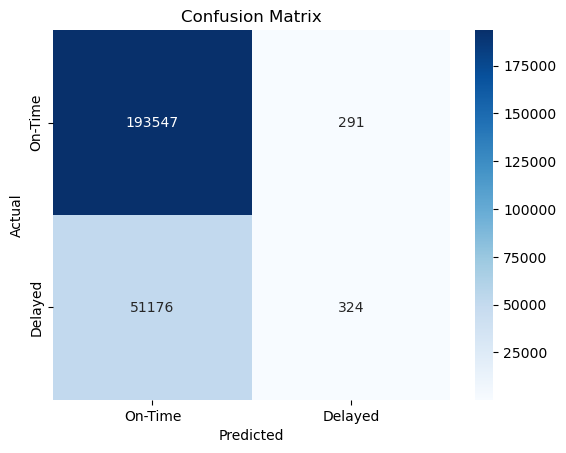

In [38]:
# Confusion matrix for test data
plot_confusion_matrix(test.iloc[:, 0], prediction_labels)

In [39]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test.iloc[:, 0], prediction_labels))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88    193838
         1.0       0.53      0.01      0.01     51500

    accuracy                           0.79    245338
   macro avg       0.66      0.50      0.45    245338
weighted avg       0.74      0.79      0.70    245338



### Observations and Insights


## Model 2 - Ensemble Model

---


### Loading Data


In [40]:
df_ensemble = data_v1.copy()

df_ensemble.shape

(1635590, 75)

In [41]:
df_ensemble.head()

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
df_ensemble_cleaned = df_ensemble.replace({True: 1, False: 0})

df_ensemble_cleaned.head(5)

,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [43]:
df_ensemble_cleaned.isnull().sum().sum()

0

In [44]:
df_ensemble_cleaned.shape

(1635590, 75)

### Train, Test and Validate Splits


In [45]:
# split the data

train, test_and_validate = train_test_split(
    df_ensemble_cleaned,
    test_size=0.3,
    random_state=42,
    stratify=df_ensemble_cleaned["target"],
)
test, validate = train_test_split(
    test_and_validate,
    test_size=0.5,
    random_state=42,
    stratify=test_and_validate["target"],
)

In [46]:
# shape of train data
train.shape

(1144913, 75)

In [47]:
# shape of test
test.shape

(245338, 75)

In [48]:
# shape of validate
validate.shape

(245339, 75)

### Uploading Data to AWS S3 Buckets


In [49]:
# set the names of the csv files
train_file = "data_v1E_train.csv"
test_file = "data_v1E_test.csv"
validate_file = "data_v1E_validate.csv"

In [50]:
# uploading data to aws s3

upload_s3_csv(train_file, "train", train)
upload_s3_csv(test_file, "test", test)
upload_s3_csv(validate_file, "validate", validate)

s3.Bucket(name='u3253992-ajulthomas-oncloud')
s3.Bucket(name='u3253992-ajulthomas-oncloud')
s3.Bucket(name='u3253992-ajulthomas-oncloud')


### Retrieving the ML model - `xgboost`


In [51]:
import boto3
from sagemaker.image_uris import retrieve

container = retrieve("xgboost", "us-east-1", version="1.0-1")

In [52]:
hyperparams = {"num_round": "42", "eval_metric": "auc", "objective": "binary:logistic"}

In [53]:
import sagemaker

# Ensure your session is set to the same region as the bucket
session = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

s3_output_location = "s3://{}/{}/output/".format(bucket, prefix)
xgb_model = sagemaker.estimator.Estimator(
    container,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    output_path=s3_output_location,
    hyperparameters=hyperparams,
    sagemaker_session=session,
)

In [54]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/{}".format(bucket, prefix, train_file), content_type="text/csv"
)

validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/{}".format(bucket, prefix, validate_file),
    content_type="text/csv",
)

print(f"channels {validate_channel} \n {train_channel}")

data_channels = {"train": train_channel, "validation": validate_channel}

channels <sagemaker.inputs.TrainingInput object at 0x7fb07705ffa0> 


### Training the model


In [55]:
xgb_model.fit(inputs=data_channels, logs=False)


2024-11-03 04:56:27 Starting - Starting the training job.
2024-11-03 04:56:40 Starting - Preparing the instances for training....
2024-11-03 04:57:07 Downloading - Downloading input data....
2024-11-03 04:57:33 Downloading - Downloading the training image...
2024-11-03 04:57:54 Training - Training image download completed. Training in progress..........
2024-11-03 04:58:44 Uploading - Uploading generated training model.
2024-11-03 04:58:57 Completed - Training job completed


### Deploying the model


In [56]:
xgb_predictor = xgb_model.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type="ml.c5.2xlarge",
)

-----!

### Creating batch input for predictions


In [57]:
# extracts the features from the test data
batch_X = test.iloc[:, 1:]

# replace all True, False Values with 1 and 0
# batch_X = batch_X.replace({True: 1, False: 0})

# filename of the batch input file while uploading to s3
batch_X_file = "batch-in.csv"

# save the batch input file
upload_s3_csv(batch_X_file, "batch-in", batch_X)

s3.Bucket(name='u3253992-ajulthomas-oncloud')


In [58]:
batch_X.isnull().sum().sum()

batch_X.shape

(245338, 74)

### Setting up batch transformation job


In [59]:
# set the output location for the batch output
batch_output = "s3://{}/{}/batch-out/".format(bucket, prefix)

# set the batch input location
batch_input = "s3://{}/{}/batch-in/{}".format(bucket, prefix, batch_X_file)

# create the transformer object from the xgb model
xgb_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output,
)

### Batch Transform


In [60]:
# starts the batch transform job
xgb_transformer.transform(
    data=batch_input, data_type="S3Prefix", content_type="text/csv", split_type="Line"
)

# waits for the batch transform job to finish
xgb_transformer.wait()

.........................2024-11-03T05:06:47.935:[sagemaker logs]: MaxConcurrentTransforms=8, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2024-11-03:05:06:43:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:05:06:43:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:05:06:43:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
[2024-11-03:05:06:43:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:05:06:43:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:05:06:43:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    

### Retrieving Prediction Results


In [72]:
# initialize the s3 client
s3 = boto3.client("s3")

# get the batch output file generated by the batch transform job
obj = s3.get_object(
    Bucket=bucket, Key="{}/batch-out/{}".format(prefix, "batch-in.csv.out")
)

# read the batch output file
target_predicted = pd.read_csv(io.BytesIO(obj["Body"].read()), names=["class"])

### Exploring results


In [73]:
# functoin to convert the predicted values to binary
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0


# convert the predicted values to binary
target_predicted_binary = target_predicted["class"].apply(binary_convert)

print(target_predicted_binary.head(5))
test.head(5)

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_Morning,DepHourofDay_Afternoon,DepHourofDay_Evening
470151,0.0,1947.0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
985696,0.0,925.0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
394886,0.0,862.0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
924542,0.0,1744.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1533313,0.0,936.0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


In [74]:
# extract the test labels
test_labels = test.iloc[:, 0]

test_labels.head(5)

470151     0.0
985696     0.0
394886     0.0
924542     0.0
1533313    0.0
Name: target, dtype: float64

### Results


#### Classification Report


In [75]:
# classification report
from sklearn.metrics import classification_report

# Classification report for test data
print("Classification Report on Test Data")
print(classification_report(test_labels, target_predicted_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85    193838
         1.0       0.40      0.30      0.34     51500

    accuracy                           0.76    245338
   macro avg       0.61      0.59      0.60    245338
weighted avg       0.74      0.76      0.75    245338



#### Confusion Matrix


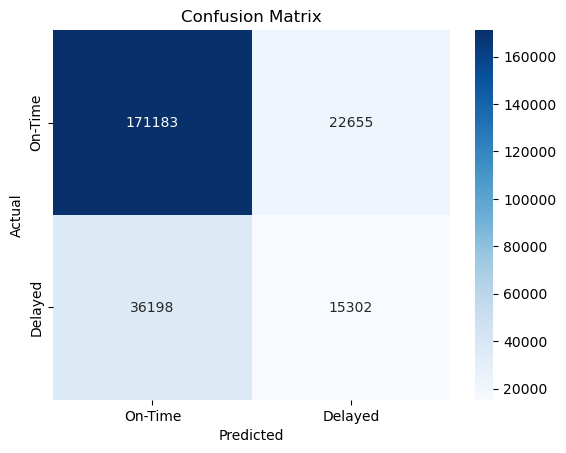

In [76]:
# plot the confusion matrix
plot_confusion_matrix(test_labels, target_predicted_binary)

In [77]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 171183
False Positive (FP): 22655
False Negative (FN): 36198
True Positive (TP) : 15302


#### Sensitivity

_Sensitivity_ is also known as _hit rate_, _recall_, or _true positive rate (TPR)_. It measures the proportion of the actual positives that are correctly identified.


In [78]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity = float(TP) / (TP + FN) * 100
print(f"Sensitivity or TPR: {Sensitivity}%")
print(
    f"There is a {Sensitivity}% chance of detecting detecting flights delayed are actually delayed."
)

Sensitivity or TPR: 29.712621359223302%
There is a 29.712621359223302% chance of detecting detecting flights delayed are actually delayed.


#### Specificity


In [79]:
# Specificity or true negative rate
Specificity = float(TN) / (TN + FP) * 100
print(f"Specificity or TNR: {Specificity}%")
print(f"There is a {Specificity}% chance of .flights on-time are actually on-time")

Specificity or TNR: 88.31240520434591%
There is a 88.31240520434591% chance of .flights on-time are actually on-time


#### Overall Accuracy


In [80]:
# Overall accuracy
ACC = float(TP + TN) / (TP + FP + FN + TN) * 100
print(f"Accuracy: {ACC}%")

Accuracy: 76.01146173849955%


#### AUC-ROC Curve


In [81]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

print("Validation AUC", roc_auc_score(test_labels, target_predicted))

Validation AUC 0.6730352404174559


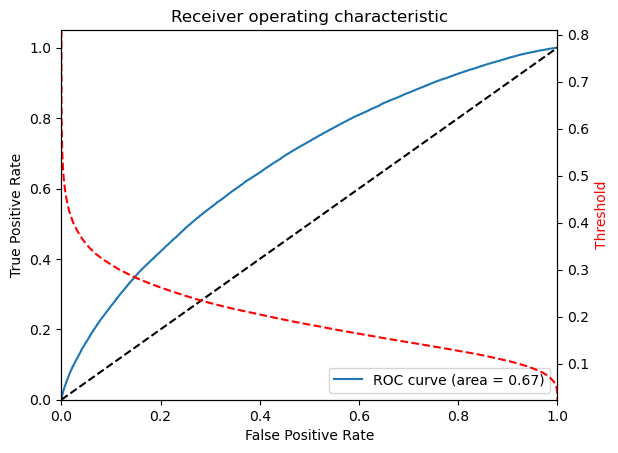

In [82]:
import numpy as np

fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)

finite_indices = np.isfinite(thresholds)
fpr_finite = fpr[finite_indices]
tpr_finite = tpr[finite_indices]
thresholds_finite = thresholds[finite_indices]

plt.figure()
plt.plot(
    fpr_finite,
    tpr_finite,
    label="ROC curve (area = %0.2f)" % auc(fpr_finite, tpr_finite),
)
plt.plot([0, 1], [0, 1], "k--")  # Dashed diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")

roc_auc = auc(fpr, tpr)

if thresholds_finite.size > 0:
    ax2 = plt.gca().twinx()
    ax2.plot(
        fpr_finite,
        thresholds_finite,
        markeredgecolor="r",
        linestyle="dashed",
        color="r",
    )
    ax2.set_ylabel("Threshold", color="r")
    ax2.set_ylim([thresholds_finite[-1], thresholds_finite[0]])
    ax2.set_xlim([fpr_finite[0], fpr_finite[-1]])

plt.show()

## Observations and Insights

---

-
